In [112]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [258]:
class Layer(object):
    """define a layer object"""
    
    def __init__(self, n_input, n_output=None, random_seed=42):
        """Constructer of a layer object"""
        
        self.n_input = n_input
        self.n_output = n_output
        
        np.random.seed(random_seed)
        self.weights = np.random.uniform(-0.43, 0.43, size=(self.n_input, self.n_output))

    def _sigmoid_forward(self, x):
        """Apply sigmoid function"""
        
        return 1 / (1 + np.exp(-x))
    
    def _tanh_forward(self, x):
        """Apply tanh function"""
        
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    
    def forward_prop(self, input_x, activation_func='sigmoid', add_noise=False):
        """Implement forward propagation"""
        
        # add gaussian noises to input
        if add_noise:
            input_x += np.random.normal(0, 0.045, size=input_x.shape)
        
        if activation_func == 'sigmoid':
            self.out_x = self._sigmoid_forward(input_x.dot(self.weights))
        elif activation_func == 'tanh':
            self.out_x = self._tanh_forward(input_x.dot(self.weights))

    def backward_prop(self, x_pre, delta_next, weights_next, eta, activation_func='sigmoid'):
        """Implement backward propagation"""
        
        if activation_func == 'sigmoid':
            self.delta = self.out_x * (1-self.out_x) * delta_next.dot(weights_next.T)
        elif activation_func == 'tanh':
            self.delta = (1 - np.square(self._tanh_forward(self.out_x))) * delta_next.dot(weights_next.T)
        
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
class Softmax_Layer(Layer):
    """define a output layer object"""
    
    def __init__(self, n_input, n_output=None, random_seed=42):
        """Constructer of a output layer object"""
            
        Layer.__init__(self, n_input, n_output, random_seed)
    
    def _softmax(self, out_x):
        return np.exp(out_x) / np.sum(np.exp(out_x))
    
    def forward_prop(self, input_x):
        """Implement forward propagation"""
        
        self.out_x = input_x.dot(self.weights)
        
    def backward_prop(self, y_true, y_preds, x_pre, eta):
        """Implement backward propagation (output layer)"""
        
        self.delta = 2 * (y_preds - y_true)
        
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
    def predict(self):
        """Predict labels"""
        
        self.pred_proba = np.apply_along_axis(self._softmax, 1, self.out_x)
        return (self.pred_proba == self.pred_proba.max(axis=1)[:, None]).astype(int)
    
    def compute_mse(self, y_true):
        """Compute mean square error"""
        
        return np.mean(np.square(self.out_x - y_true))
    
    def compute_miscla_rate(self, y_true):
        """Compute misclassification rate"""
        
        return 1 - np.sum(np.all(output_layer.predict() == y_true, axis=1)) / y_true.shape[0]

## Task 1

In [157]:
X = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])

In [158]:
epochs = 10000
n_neurons = 2
fc_layer = Layer(X.shape[1], n_neurons)
output_layer = Softmax_Layer(n_neurons, 2)

In [159]:
errors = np.zeros(epochs)
for epoch in range(epochs):
    fc_layer.forward_prop(X)
    output_layer.forward_prop(fc_layer.out_x)
    
    y_preds = output_layer.predict()
    output_layer.backward_prop(y, y_preds, x_pre=fc_layer.out_x, eta=0.035)
    fc_layer.backward_prop(x_pre=X, delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.035)
    
    errors[epoch] = output_layer.compute_mse(y)

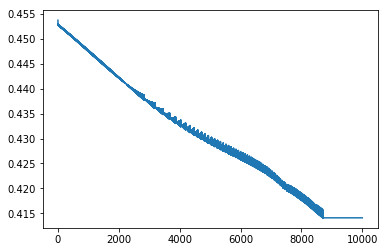

In [160]:
plt.plot(errors)

## Bonus Task

In [259]:
# load data
X = np.loadtxt('input/mfeat-pix.txt')

# normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# X = (X - np.min(X)) / (np.max(X) - np.min(X))

# add bias term
X = np.column_stack([np.ones(X.shape[0]), X])

# split the dataset into training data and test data
train_indices = [range(0 + 200*i, 100 + 200*i) for i in range(10)]
test_indices = [range(100 + 200*i, 200 + 200*i) for i in range(10)]

X_train = X[train_indices, ].reshape(1000, 241)
X_test = X[test_indices, ].reshape(1000, 241)

In [260]:
# create class labels
nb_classes = 10
y_vector = np.array([i for i in range(10) for j in range(100)])
y_matrix = np.eye(nb_classes)[y_vector]

In [261]:
# set the architecture
epochs = 10000
neurons_1 = 256
neurons_2 = 256
fc_layer1 = Layer(X.shape[1], neurons_1)
fc_layer2 = Layer(neurons_1, neurons_2)
output_layer = Softmax_Layer(neurons_2, 10)

train_miss = np.zeros(epochs)
test_miss = np.zeros(epochs)

In [ ]:
for epoch in range(epochs):
    fc_layer1.forward_prop(X_train, activation_func='tanh', add_noise=True)
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh', add_noise=True)
    output_layer.forward_prop(fc_layer2.out_x)
    
    train_miss[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    output_layer.backward_prop(y_matrix, output_layer.predict(), x_pre=fc_layer2.out_x, eta=0.004)
    fc_layer2.backward_prop(x_pre=fc_layer1.out_x, activation_func='tanh', delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.01)
    fc_layer1.backward_prop(x_pre=X_train, activation_func='tanh', delta_next=fc_layer2.delta, weights_next=fc_layer2.weights, eta=0.01)
    
    fc_layer1.forward_prop(X_test, activation_func='tanh')
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh')
    output_layer.forward_prop(fc_layer2.out_x)
    
    test_miss[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    if epoch % 10 == 0:
        print(epoch, train_miss[epoch], test_miss[epoch])

0 0.924 0.876
10 0.44399999999999995 0.43999999999999995
20 0.28900000000000003 0.29800000000000004
30 0.23199999999999998 0.247
40 0.18600000000000005 0.20799999999999996
50 0.15500000000000003 0.18700000000000006
60 0.15200000000000002 0.17500000000000004
70 0.133 0.16200000000000003
80 0.10999999999999999 0.14700000000000002
90 0.10299999999999998 0.14300000000000002
100 0.11499999999999999 0.139
110 0.10299999999999998 0.129
120 0.09099999999999997 0.124
130 0.09099999999999997 0.122
140 0.09399999999999997 0.11699999999999999
150 0.10299999999999998 0.11499999999999999
160 0.09199999999999997 0.11399999999999999
170 0.10199999999999998 0.10799999999999998
180 0.09599999999999997 0.10799999999999998
190 0.08299999999999996 0.10199999999999998
200 0.07799999999999996 0.09999999999999998
210 0.08799999999999997 0.09499999999999997
220 0.07699999999999996 0.09199999999999997
230 0.07299999999999995 0.09099999999999997
240 0.07499999999999996 0.08899999999999997
250 0.07699999999999996